## Investment Algorithm Accuracy Simulation

This notebook simulates the accuracy of different investment algorithms in an uncertain environment. It compares the performance of four different AI models against a benchmark of perfect knowledge. The simulation involves a simple investment task where an agent must decide between investing in a risky asset (a share) or a safe asset (a bond) over multiple trials.

### Setup and Parameters
This section sets up the necessary libraries and parameters for the simulation.

- It imports libraries like NumPy, Pandas, Matplotlib, Seaborn, and tqdm.
- It sets a random seed for reproducibility.
- It defines key parameters such as the prior probabilities of a good share (`p`), the probability of a high payoff for a good share (`q`), the payoff values for high and low outcomes (`high_payoff`, `low_payoff`), the bond payoff (`bond_payoff`), the number of trials per block (`num_trials`), and the number of simulations to run (`num_simulations`).

In [205]:
# Setup and Parameters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tqdm import tqdm  # For progress bars
from dataclasses import dataclass
from typing import List, Dict, Tuple, Any, Optional

# Set random seed for reproducibility
np.random.seed(20250410)

## Configuration dataclass for global parameters
@dataclass(frozen=True)
class SimulationConfig:
    p: List[float]               # Prior probabilities of good share
    q: float                     # Probability of high payoff for good share
    high_payoff: float           # Y value - high payoff amount
    low_payoff: float            # Z value - low payoff amount
    bond_payoff: float           # X value - safe bond payoff amount
    num_trials: int              # Trials per block
    num_simulations: int         # Number of simulations to run
    ai_types: List[str]          # Types of AI to simulate
    beta: float                  # Conservatism parameter

# Create default configuration
DEFAULT_CONFIG = SimulationConfig(
    p=[0.2, 0.5, 0.8],
    q=0.7,
    high_payoff=5,
    low_payoff=1,
    bond_payoff=3,
    num_trials=13,
    num_simulations=10000,
    ai_types=['perfect', 'shortsighted', 'earlycommitment', 'conservative', 'naiveprior'],
    beta=0.5
)


### Core Functions

This section defines the core functions for the investment task simulation and analytical solution:

- `simulate_outcomes`: Simulates the outcomes (high or low) for a given share type (good or bad) over a specified number of trials. It uses the `q` probability to determine the likelihood of each outcome.
- `calculate_expected_return`: Calculates the expected return for the risky asset (share) based on the posterior probability of it being good. This is used to make informed investment decisions.
- `get_correct_decision`: Determines the optimal investment decision (share or bond) given the true share type. This represents perfect knowledge and serves as a benchmark for evaluating the AI models.
- `calculate_posterior`: Calculates the posterior probability based on the AI type and available information:
  - For 'perfect': Uses Bayes' rule with all available data, representing the ideal scenario with perfect knowledge and reasoning.
  - For 'shortsighted': Calculates the posterior based only on the most recent outcome, representing an AI with limited memory or focus.
  - For 'earlycommitment': Calculates the posterior based solely on the first outcome, representing an AI that makes an early judgment and sticks to it.
  - For 'conservative': Calculates the posterior using a conservative approach, where it updates insufficiently based on the outcomes.
  - For 'naiveprior': Calculates the posterior using all data but assumes a fixed 50/50 prior, representing an AI with an inaccurate understanding of the prior probabilities.
- the `get_ai_recommendation` function, which determines the AI's investment recommendation (share, bond, or indifferent) based on the AI type and the available information.
  - It takes the AI type, prior probability, outcomes so far, and the current trial number as input.
  - It calculates the posterior probability using the appropriate AI type.
  - It calculates the expected return based on the posterior.
  - It compares the expected return to the bond payoff and makes a recommendation accordingly.

In [206]:
# Investment Task Simulation Functions
def simulate_outcomes(share_type: str, config: SimulationConfig) -> List[str]:
    """
    Simulate high/low outcomes for a given share type

    Parameters:
        share_type: 'good' or 'bad' - the actual quality of the share
        config: Simulation configuration parameters

    Returns:
        Array of 'high' or 'low' outcomes for each trial
    """
    if share_type == 'good':
        outcomes = np.random.choice(['high', 'low'], size=config.num_trials, p=[config.q, 1-config.q])
        return outcomes.tolist()  # Convert to list
    else:  # share_type == 'bad'
        outcomes = np.random.choice(['high', 'low'], size=config.num_trials, p=[1-config.q, config.q])
        return outcomes.tolist()  # Convert to list

def calculate_expected_return(posterior_good: float, config: SimulationConfig) -> float:
    """
    Calculate expected return for the risky asset based on posterior probability

    Parameters:
        posterior_good: probability that the share is good
        config: Simulation configuration parameters

    Returns:
        Expected monetary return of investing in the share
    """
    posterior_bad = 1 - posterior_good

    # Calculate expected return using equation from the experiment design
    return (posterior_good * config.q * config.high_payoff +
            posterior_bad * (1-config.q) * config.high_payoff +
            posterior_good * (1-config.q) * config.low_payoff +
            posterior_bad * config.q * config.low_payoff)

def get_correct_decision(true_share_type: str, config: SimulationConfig) -> str:
    """
    Determine the correct investment decision given the true share type

    Parameters:
        true_share_type: 'good' or 'bad' - the actual quality of the share
        config: Simulation configuration parameters

    Returns:
        'share' or 'bond' or 'indifferent' - the optimal investment choice
    """
    # If we know the true share type, posterior probability is either 0 or 1
    p_good = 1 if true_share_type == 'good' else 0
    expected_return = calculate_expected_return(p_good, config)

    if expected_return > config.bond_payoff:
        return 'share'
    elif expected_return < config.bond_payoff:
        return 'bond'
    else:
        return 'indifferent'

In [207]:
# Bayesian Posterior Calculation Function
def calculate_posterior(ai_type: str, p: float, outcomes: List[str], current_trial: int, config: SimulationConfig) -> float:
    """
    Calculate posterior probability based on AI type and available information

    Parameters:
        ai_type: 'perfect', 'shortsighted', 'earlycommitment', 'conservative' or 'naiveprior'
        p: prior probability of good share
        outcomes: list of all outcomes so far
        current_trial: the current trial number (0-indexed)
        config: Simulation configuration parameters

    Returns:
        Updated probability that the share is good
    """
    if not outcomes:
        return p  # No evidence yet, return the prior
    
    # Handle different AI types
    if ai_type == 'shortsighted':
        # Short-sighted AI only considers the most recent outcome
        outcomes = [outcomes[-1]]
    elif ai_type == 'earlycommitment':
        # Early commitment AI only uses the first outcome
        outcomes = [outcomes[0]]
    elif ai_type == 'naiveprior':
        # Naïve prior AI uses all data but always assumes a 50/50 prior
        p = 0.5
    
    # Count high and low outcomes
    nH = sum(1 for o in outcomes if o == 'high')
    nL = len(outcomes) - nH
    
    # Calculate posterior using Bayes' rule
    if ai_type == 'conservative':
        # Conservative AI updates insufficiently
        numerator = p * ((config.q ** nH) * ((1-config.q) ** nL)) ** config.beta
        denominator = numerator + (1-p) * (((1-config.q) ** nH) * (config.q ** nL)) ** config.beta
    else:
        # Standard Bayesian update for other AI types
        numerator = p * (config.q ** nH) * ((1-config.q) ** nL)
        denominator = numerator + (1-p) * ((1-config.q) ** nH) * (config.q ** nL)
    
    return numerator / denominator if denominator != 0 else p

In [208]:
# AI Decision Function
def get_ai_recommendation(ai_type: str, p: float, outcomes: List[str], current_trial: int, config: SimulationConfig) -> str:
    """
    Determine AI's recommendation based on AI type and available information

    Parameters:
        ai_type: AI model type
        p: prior probability of good share
        outcomes: list of all outcomes so far
        current_trial: the current trial number (0-indexed)
        config: Simulation configuration parameters

    Returns:
        'share', 'bond', or 'indifferent' - the AI's recommendation
    """
    # Calculate posterior probability based on AI type
    posterior_good = calculate_posterior(ai_type, p, outcomes, current_trial, config)
    
    # Calculate expected return and make recommendation
    expected_return = calculate_expected_return(posterior_good, config)

    if expected_return > config.bond_payoff:
        return 'share'
    elif expected_return < config.bond_payoff:
        return 'bond'
    else:
        return 'indifferent'

## Metric calculation functions

It calculates exact probabilities for all possible outcome sequences rather than using simulation.

1. **Ex-Ante correctness**: Evaluates if the AI's recommendation matches the optimal decision based on perfect Bayesian reasoning given available information. It measures statistical optimality regardless of outcome.

2. **Ex-Post Type correctness**: Evaluates if the AI's recommendation matches what would have been optimal given perfect knowledge of the share type (good vs bad). This measures alignment with the true underlying asset quality.

3. **Ex-Post Payoff correctness**: Evaluates if the AI's recommendation maximized payoff given the actual outcome (high vs low). This measures whether the decision was rewarded by the specific outcome that occurred.


In [209]:
##########################
# Three correctness measures
##########################

def measure_ex_ante_correctness(ai_rec: str, true_bayes_post: float, config: SimulationConfig) -> float:
    """
    1) Ex-Ante correctness = does the AI's action match the *fully* Bayesian (perfect) EV?
       - If EV(share) > bond => share is correct
       - If EV(share) < bond => bond  is correct
       - If tie => all are correct
    """
    ev_share_correct = calculate_expected_return(true_bayes_post, config)
    if abs(ev_share_correct - config.bond_payoff) < 1e-15:
        # Perfect tie => full credit for any rec
        return 1.0
    elif ev_share_correct > config.bond_payoff:
        return 1.0 if ai_rec == 'share' else 0.0
    else:
        return 1.0 if ai_rec == 'bond' else 0.0

def measure_ex_post_share_type(ai_rec: str, share_type: str) -> float:
    """
    2) Old Ex-post measure (share-type):
       - If share is good => share=1, bond=0, indifferent=0.5
       - If share is bad  => bond=1, share=0, indifferent=0.5
    """
    if share_type == 'good':
        if ai_rec == 'share':
            return 1.0
        elif ai_rec == 'indifferent':
            return 0.5
        else:  # bond
            return 0.0
    else:  # bad
        if ai_rec == 'bond':
            return 1.0
        elif ai_rec == 'indifferent':
            return 0.5
        else:  # share
            return 0.0

def measure_ex_post_payoff(ai_rec: str, outcome: str) -> float:
    """
    3) Payoff-based ex-post:
       If outcome='high' => share=1, bond=0, indifferent=0.5
       If outcome='low'  => bond=1, share=0, indifferent=0.5
    """
    if outcome == 'high':
        if ai_rec == 'share':
            return 1.0
        elif ai_rec == 'bond':
            return 0.0
        else:  # indifferent
            return 0.5
    else:  # 'low'
        if ai_rec == 'bond':
            return 1.0
        elif ai_rec == 'share':
            return 0.0
        else:
            return 0.5
        
def calculate_accuracy_metrics(ai_rec: str, true_posterior: float, true_share_type: str, 
                              outcome: str, ev_optimal: str) -> Dict[str, float]:
    """
    Calculate all three accuracy metrics for an AI recommendation
    
    Parameters:
        ai_rec: AI recommendation ('share', 'bond', or 'indifferent')
        true_posterior: True Bayesian posterior probability of good share
        true_share_type: Actual share type ('good' or 'bad')
        outcome: Actual outcome ('high' or 'low')
        ev_optimal: Statistically optimal decision ('share', 'bond', or 'indifferent')
        
    Returns:
        Dictionary containing all three accuracy metrics
    """
    # 1. Ex-ante accuracy (statistical optimality)  
    ex_ante = measure_ex_ante_correctness(ai_rec, true_posterior, DEFAULT_CONFIG)

    # 2. Ex-post type accuracy (share-type correctness)
    ex_post_type = measure_ex_post_share_type(ai_rec, true_share_type)
    
    # 3. Ex-post payoff accuracy (outcome-based)
    ex_post_payoff = measure_ex_post_payoff(ai_rec, outcome)
    
    return {
        'ex_ante': ex_ante,
        'ex_post_type': ex_post_type,
        'ex_post_payoff': ex_post_payoff
    }


### Simulation analysis

This section defines functions for running the simulations and aggregating the results:

- `run_simulation`: Runs a single simulation of the investment task for a given prior probability (`p`). It simulates outcomes, calculates the correct decision, tracks the AI recommendations, and calculates accuracy metrics.
- `run_all_simulations`: Runs simulations for all prior probabilities (`p`) and aggregates the results across multiple simulations.

In [ ]:
# Simulation Runner Functions
    
def run_simulation(p: float, sim_id: int, config: SimulationConfig) -> Tuple[Dict[str, Dict[str, float]], List[Dict]]:
    """
    Run a single simulation of the investment task
    
    Parameters:
        p: Prior probability of good share
        sim_id: Simulation ID
        config: Simulation configuration parameters
        
    Returns:
        Tuple containing:
        - Dictionary of AI performance metrics
        - List of detailed trial data
    """
    # Determine if the share is good or bad based on prior probability
    share_type = 'good' if np.random.random() < p else 'bad'
    
    # Simulate outcomes for all trials
    outcomes = simulate_outcomes(share_type, config)
    
    # Get the correct decision based on the true share type
    correct_decision = get_correct_decision(share_type, config)
    
    # Track recommendations and metrics for each AI type
    ai_metrics = {ai_type: {'ex_ante': 0, 'ex_post_type': 0, 'ex_post_payoff': 0} for ai_type in config.ai_types}
    detailed_data = []
    
    # Simulate AI recommendations at each trial
    for trial in range(1, config.num_trials + 1):
        # Get outcomes observed so far (excluding current trial)
        observed_outcomes = outcomes[:trial-1]
        current_outcome = outcomes[trial-1]
        
        # Get true Bayesian posterior for EV measure
        true_posterior = calculate_posterior('perfect', p, observed_outcomes, trial-1, config)
        
        # Calculate expected return based on true posterior
        expected_return = calculate_expected_return(true_posterior, config)
        
        # Determine optimal decision based on expected return
        if expected_return > config.bond_payoff:
            ev_optimal_decision = 'share'
        elif expected_return < config.bond_payoff:
            ev_optimal_decision = 'bond'
        else:
            ev_optimal_decision = 'indifferent'
        
        # For each AI type, get recommendation and measure correctness
        for ai_type in config.ai_types:
            ai_rec = get_ai_recommendation(ai_type, p, observed_outcomes, trial-1, config)
            
            # Ex-Ante correctness (match with statistical optimality)
            ex_ante_correct = measure_ex_ante_correctness(ai_rec, true_posterior, config)

            # Ex-Post Type correctness (match with true share type)
            ex_post_type_correct = measure_ex_post_share_type(ai_rec, share_type)
            
            # Ex-Post Payoff correctness (match with actual outcome)
            ex_post_payoff_correct = measure_ex_post_payoff(ai_rec, current_outcome)
            
            # Add to metrics
            ai_metrics[ai_type]['ex_ante'] += ex_ante_correct
            ai_metrics[ai_type]['ex_post_type'] += ex_post_type_correct
            ai_metrics[ai_type]['ex_post_payoff'] += ex_post_payoff_correct
            
            # Record detailed data for this trial
            detailed_data.append({
                'sim_id': sim_id,
                'prior': p,
                'trial': trial,
                'ai_type': ai_type,
                'true_share_type': share_type,
                'outcome': current_outcome,
                'ai_rec': ai_rec,
                'ev_optimal': ev_optimal_decision,
                'ev_accuracy': ex_ante_correct,
                'rec_accuracy': ex_post_type_correct,
                'outcome_accuracy': ex_post_payoff_correct
            })
    
    # Convert trial sums to averages
    for ai_type in config.ai_types:
        for metric in ai_metrics[ai_type]:
            ai_metrics[ai_type][metric] /= config.num_trials
    
    return ai_metrics, detailed_data

def run_all_simulations(config: SimulationConfig, num_simulations_to_run: Optional[int] = None) -> Tuple[Dict[float, Dict[str, Dict[str, float]]], pd.DataFrame]:
    """
    Run simulations for all prior probabilities
    
    Parameters:
        config: Simulation configuration parameters
        num_simulations_to_run: Optional override for number of simulations
        
    Returns:
        Tuple with results dictionary and DataFrame with detailed trial data
    """
    if num_simulations_to_run is None:
        num_simulations_to_run = config.num_simulations
        
    results = {}
    all_detailed_data = []
    
    for p in config.p:
        # Initialize accumulators for this prior
        sums = {ai_type: {metric: 0.0 for metric in ['ex_ante', 'ex_post_type', 'ex_post_payoff']} 
                for ai_type in config.ai_types}

        # Run simulations for this prior probability
        for sim_id in tqdm(range(num_simulations_to_run), desc=f"Simulating p={p}"):
            sim_results, detailed_data = run_simulation(p, sim_id, config)
            
            # Collect detailed data
            all_detailed_data.extend(detailed_data)

            # Aggregate results
            for ai_type in config.ai_types:
                for metric in sums[ai_type]:
                    sums[ai_type][metric] += sim_results[ai_type][metric]

        # Average the results
        results[p] = {}
        for ai_type in config.ai_types:
            results[p][ai_type] = {metric: sums[ai_type][metric] / num_simulations_to_run 
                                  for metric in sums[ai_type]}

    # Convert detailed data to DataFrame
    trial_df = pd.DataFrame(all_detailed_data)
    
    return results, trial_df

## Analytical solution

This section provides the functions for the analytical solution. It comprises the following functions:

- `seq_probability`: Calculates the probability of a specific sequence of outcomes given the share type (good or bad) and the prior probability.
- `run_all_measures`: Runs the analytical solution for all measures (ex-ante, ex-post type, and ex-post payoff) across all prior probabilities and outcomes.

In [211]:

##########################
# Probability of a sequence
##########################

def seq_probability(sequence: np.ndarray, share_type: str, config: SimulationConfig) -> float:
    """
    Probability of seeing 'sequence' if the share is good or bad.
    
    Parameters:
        sequence: Array of 'high' or 'low' outcomes
        share_type: 'good' or 'bad'
        config: Simulation configuration parameters
        
    Returns:
        Probability of the sequence occurring
    """
    # Convert sequence to binary array (1 for high, 0 for low)
    if isinstance(sequence, np.ndarray):
        # If already numpy array, use it directly
        seq_arr = sequence
    else:
        # Convert list of strings to binary array
        seq_arr = np.array([1 if o == 'high' else 0 for o in sequence])
    
    # Count high outcomes
    nH = np.sum(seq_arr)
    # Count low outcomes
    nL = len(seq_arr) - nH
    
    if share_type == 'good':
        return (config.q ** nH) * ((1.0 - config.q) ** nL)
    else:
        return ((1.0 - config.q) ** nH) * (config.q ** nL)
    
##########################
# Main enumeration function
##########################

def run_all_measures(config: SimulationConfig) -> Dict[float, Dict[str, Dict[str, float]]]:
    """
    Enumerates all 2^num_trials sequences, simulates each AI's picks,
    and calculates three measures of accuracy using NumPy for vectorization.
    
    Parameters:
        config: Simulation configuration parameters
    
    Returns:
        Nested dictionary with results for each prior and AI type
    """
    # Pre-generate all possible sequences as binary arrays (0=low, 1=high)
    # This gives us a 2D array where each row is one possible sequence
    sequences = np.array(list(itertools.product([0, 1], repeat=config.num_trials)))
    
    # Results dictionary
    results = {}
    
    # For each prior probability
    for p in config.p:
        print(f"Calculating analytical solution for p={p}")
        
        # Pre-calculate probabilities for all sequences
        # Probability of sequence if share is good
        probs_good = np.zeros(len(sequences))
        # Probability of sequence if share is bad
        probs_bad = np.zeros(len(sequences))
        
        # Pre-convert sequences to string representations for processing
        seq_strings = []
        for seq in sequences:
            # Convert binary (0,1) to ('low','high')
            seq_str = ['high' if bit == 1 else 'low' for bit in seq]
            seq_strings.append(seq_str)
            
            # Calculate probabilities for this sequence
            prob_good = seq_probability(seq, 'good', config)
            prob_bad = seq_probability(seq, 'bad', config)
            
            # Store in arrays
            probs_good[len(seq_strings)-1] = prob_good
            probs_bad[len(seq_strings)-1] = prob_bad
        
        # Initialize measures for each AI type
        measure_sums = {
            ai_type: {
                'ex_ante': 0.0,
                'ex_post_type': 0.0,
                'ex_post_payoff': 0.0
            }
            for ai_type in config.ai_types
        }
        
        # For each possible sequence
        for i, (seq, seq_str) in enumerate(zip(sequences, seq_strings)):
            # Probability weights
            prob_good = probs_good[i]
            prob_bad = probs_bad[i]
            seq_weight = p * prob_good + (1.0 - p) * prob_bad
            
            # Skip sequences with near-zero probability to save computation
            if seq_weight < 1e-10:
                continue
            
            # For each AI type
            for ai_type in config.ai_types:
                # Tracking correctness measures
                correct_ex_ante = 0.0
                correct_ex_post_good = 0.0
                correct_ex_post_bad = 0.0
                correct_ex_post_payoff = 0.0
                
                # Simulate the AI observing outcomes one by one
                observed = []
                for t, outcome in enumerate(seq_str):
                    # Get AI recommendation based on observations so far
                    current_trial = len(observed)
                    ai_rec = get_ai_recommendation(ai_type, p, observed, current_trial, config)
                    
                    # Calculate true Bayesian posterior for EV measure
                    true_posterior_good = calculate_posterior('perfect', p, observed, current_trial, config)
                    
                    # 1) Ex-Ante correctness
                    correct_ex_ante += measure_ex_ante_correctness(ai_rec, true_posterior_good, config)
                    
                    # 2) Ex-Post (share-type) correctness
                    correct_ex_post_good += measure_ex_post_share_type(ai_rec, 'good')
                    correct_ex_post_bad += measure_ex_post_share_type(ai_rec, 'bad')
                    
                    # 3) Ex-Post (payoff-based) correctness
                    correct_ex_post_payoff += measure_ex_post_payoff(ai_rec, outcome)
                    
                    # Update observed outcomes for next trial
                    observed.append(outcome)
                
                # Update measure sums with sequence-weighted correctness
                measure_sums[ai_type]['ex_ante'] += correct_ex_ante * seq_weight
                
                measure_sums[ai_type]['ex_post_type'] += (
                    correct_ex_post_good * (p * prob_good) +
                    correct_ex_post_bad * ((1.0 - p) * prob_bad)
                )
                
                measure_sums[ai_type]['ex_post_payoff'] += correct_ex_post_payoff * seq_weight
        
        # Process results for this prior probability
        final_for_p = {}
        for ai_type in config.ai_types:
            # Convert sums to fractions by dividing by number of trials
            final_for_p[ai_type] = {
                'ex_ante': measure_sums[ai_type]['ex_ante'] / float(config.num_trials),
                'ex_post_type': measure_sums[ai_type]['ex_post_type'] / float(config.num_trials),
                'ex_post_payoff': measure_sums[ai_type]['ex_post_payoff'] / float(config.num_trials)
            }
        
        results[p] = final_for_p
    
    return results

### Visualisation and reporting functions

This section defines functions for creating summary visualisations of the results:

- `create_performance_summary`: Creates a bar chart comparing the overall performance of all AI models using both traditional and EV-based accuracy measures.
- `plot_performance_by_prior`: Creates bar charts showing the performance of AI models across different prior probabilities, using both traditional and EV-based accuracy measures.
- `create_dynamic_x_ticks`: Helper for dynamic x-ticks in plots.
- `plot_accuracy_by_trial`: Creates a plot visualizing the accuracy of AI models across trials for different prior probabilities.
- `plot_combined_accuracy_by_trial`: Creates a combined plot visualizing the accuracy of AI models across trials for different prior probabilities.
- `plot_analytical_performance_by_prior`: Creates a plot visualizing the analytical performance of AI models across different prior probabilities.
- `create_table_from_results` takes the results dictionaries (containing accuracy data) and a `table_type` parameter to create formatted tables summarizing the AI models' performance. It takes three parameters and creates either a summary table (overall AI performance) or a prior probability table (performance for each prior).
    - `results`: A dictionary containing the traditional accuracy results from the simulations.
    - `ev_results`: A dictionary containing the expected value (EV)-based accuracy results from the simulations.
    - `table_type`: A string indicating the type of table to generate ("summary" or "prior").
- `plot_trial_by_trial_performance`: Creates a plot visualizing the traditional accuracy of AI models across trials for different prior probabilities.

In [212]:
# Visualisation Functions
def create_performance_summary(results: Dict[float, Dict[str, Dict[str, float]]], config: SimulationConfig) -> plt.Figure:
    """
    Create a clear performance summary chart comparing all AI models
    
    Parameters:
        results: Dictionary with accuracy results in consistent format
        config: Simulation configuration parameters
        
    Returns:
        matplotlib figure
    """
    # Calculate average accuracy across all priors for all measures
    ex_ante_accuracy = {}      # EV-based
    ex_post_type_accuracy = {} # Traditional
    ex_post_payoff_accuracy = {} # Payoff-based

    for ai_type in config.ai_types:
        # Calculate average accuracy across all priors
        ex_ante_sum = sum(results[p][ai_type]['ex_ante'] for p in config.p)
        ex_post_type_sum = sum(results[p][ai_type]['ex_post_type'] for p in config.p)
        ex_post_payoff_sum = sum(results[p][ai_type]['ex_post_payoff'] for p in config.p)
        
        # Average across priors
        ex_ante_accuracy[ai_type] = ex_ante_sum / len(config.p)
        ex_post_type_accuracy[ai_type] = ex_post_type_sum / len(config.p)
        ex_post_payoff_accuracy[ai_type] = ex_post_payoff_sum / len(config.p)

    # Create DataFrame for plotting
    summary_data = []
    for ai_type in config.ai_types:
        summary_data.append({
            'AI Type': ai_type.capitalize(),
            'Accuracy Measure': 'Ex-Ante',
            'Accuracy': ex_ante_accuracy[ai_type]
        })
        summary_data.append({
            'AI Type': ai_type.capitalize(),
            'Accuracy Measure': 'Ex-Post Type',
            'Accuracy': ex_post_type_accuracy[ai_type]
        })
        summary_data.append({
            'AI Type': ai_type.capitalize(),
            'Accuracy Measure': 'Ex-Post Payoff',
            'Accuracy': ex_post_payoff_accuracy[ai_type]
        })

    df = pd.DataFrame(summary_data)

    # Create a grouped bar chart
    fig = plt.figure(figsize=(12, 7))
    ax = plt.gca()

    # Use custom colors
    palette = {
        'Ex-Ante': '#2ecc71',       # Green
        'Ex-Post Type': '#3498db',  # Blue
        'Ex-Post Payoff': '#e67e22' # Orange
    }

    # Create the grouped bar chart
    sns.barplot(
        x='AI Type',
        y='Accuracy',
        hue='Accuracy Measure',
        data=df,
        palette=palette,
        ax=ax
    )

    # Format the plot
    ax.set_title('AI Performance Comparison', fontsize=14)
    ax.set_xlabel('AI Model', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Format y-axis as percentages
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

    # Add value labels on the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='{:.1f}%', padding=3, label_type='edge',
                   fontsize=10, fontweight='bold')

    plt.tight_layout()
    return fig

def plot_performance_by_prior(results: Dict[float, Dict[str, Dict[str, float]]], config: SimulationConfig) -> plt.Figure:
    """
    Create a chart showing performance across different prior probabilities

    Parameters:
        results: Dictionary with all accuracy results in consistent format
        config: Simulation configuration parameters

    Returns:
        matplotlib figure
    """
    # Calculate accuracy for each prior and AI type
    data = []

    for p in config.p:
        for ai_type in config.ai_types:
            # Access metrics directly from results
            ex_ante = results[p][ai_type]['ex_ante']
            ex_post_type = results[p][ai_type]['ex_post_type']
            ex_post_payoff = results[p][ai_type]['ex_post_payoff']

            # Add to data
            data.append({
                'Prior Probability': p,
                'AI Type': ai_type.capitalize(),
                'Statistical Optimality': ex_ante,
                'Correct Predictions': ex_post_type,
                'Payoff Accuracy': ex_post_payoff
            })

    df = pd.DataFrame(data)

    # Create figure with three subplots side by side
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Plot Statistical Optimality (Ex-Ante)
    sns.barplot(x='Prior Probability', y='Statistical Optimality', hue='AI Type',
                data=df, ax=ax1, palette='Greens')

    ax1.set_title('AI Statistical Optimality (Ex-Ante)')
    ax1.set_ylabel('Statistical Optimality (%)')
    ax1.set_ylim(0, 1)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.legend(loc='lower right')

    # Format y-axis as percentages
    ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax1.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

    # 2. Plot Correct Predictions (Ex-Post Type)
    sns.barplot(x='Prior Probability', y='Correct Predictions', hue='AI Type',
                data=df, ax=ax2, palette='Blues')

    ax2.set_title('AI Correct Predictions (Ex-Post Type)')
    ax2.set_ylabel('Correct Prediction Rate (%)')
    ax2.set_ylim(0, 1)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    ax2.legend(loc='lower right')

    # Format y-axis as percentages
    ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax2.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    
    # 3. Plot Payoff Accuracy (Ex-Post Payoff)
    sns.barplot(x='Prior Probability', y='Payoff Accuracy', hue='AI Type',
                data=df, ax=ax3, palette='Oranges')

    ax3.set_title('AI Payoff Accuracy (Ex-Post Payoff)')
    ax3.set_ylabel('Payoff Accuracy (%)')
    ax3.set_ylim(0, 1)
    ax3.grid(axis='y', linestyle='--', alpha=0.7)
    ax3.legend(loc='lower right')

    # Format y-axis as percentages
    ax3.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax3.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

    plt.tight_layout()
    return fig

# Dynamic grid function for plotting
def create_dynamic_x_ticks(max_trials: int) -> List[int]:
    """
    Create dynamic x-ticks based on the number of trials:
    - If max_trials <= 11: Show grid lines for all trials
    - If max_trials > 11: Show grid lines for odd-numbered trials plus the last trial if even
    
    Parameters:
        max_trials: Maximum number of trials
        
    Returns:
        List of x-tick positions
    """
    if max_trials <= 11:
        # If 11 or fewer trials, show all
        x_ticks = list(range(1, max_trials + 1))
    else:
        # For more than 11 trials, show odd-numbered trials
        x_ticks = [i for i in range(1, max_trials + 1) if i % 2 == 1]
        
        # Always include the last trial if it's not already included (if it's even)
        if max_trials % 2 == 0 and max_trials not in x_ticks:
            x_ticks.append(max_trials)
    
    return sorted(x_ticks)

# Plot_accuracy_by_trial function
def plot_accuracy_by_trial(trial_df: pd.DataFrame, accuracy_measure: str = 'ev_accuracy', 
                          title_prefix: str = 'AI', config: SimulationConfig = None) -> plt.Figure:
    """
    Plot accuracy across trials for all AI types with dynamic grid
    
    Parameters:
        trial_df: DataFrame with trial-by-trial data
        accuracy_measure: Column name for the accuracy measure to plot
        title_prefix: Prefix for the plot title
        config: Simulation configuration parameters
        
    Returns:
        matplotlib figure
    """
    # Group by prior, trial, and AI type to get average performance
    grouped = trial_df.groupby(['prior', 'trial', 'ai_type'])[accuracy_measure].mean().reset_index()

    # Create a figure with subplots for each prior
    fig, axes = plt.subplots(len(config.p), 1, figsize=(12, 15), sharex=True)
    
    # Determine the max number of trials
    max_trials = trial_df['trial'].max()
    
    # Create dynamic x-ticks
    x_ticks = create_dynamic_x_ticks(max_trials)

    # Map accuracy measures to readable labels
    measure_labels = {
        'ev_accuracy': 'Statistical Optimality',
        'rec_accuracy': 'Ex-Post Type Accuracy',
        'outcome_accuracy': 'Ex-Post Payoff Accuracy'
    }
    
    measure_label = measure_labels.get(accuracy_measure, accuracy_measure.replace('_', ' ').title())

    # Plot for each prior probability
    for i, p in enumerate(config.p):
        ax = axes[i]
        data = grouped[grouped['prior'] == p]

        # Plot each AI type
        for ai_type in config.ai_types:
            ai_data = data[data['ai_type'] == ai_type]
            ax.plot(ai_data['trial'], ai_data[accuracy_measure],
                   marker='o', label=ai_type.capitalize(), linewidth=2)

        ax.set_title(f'{title_prefix} {measure_label} Across Trials (Prior p={p})')
        ax.set_ylim(0, 1.05)
        ax.set_ylabel(measure_label)
        ax.legend(loc='lower right')
        
        # Set dynamic x-axis ticks and grid
        ax.set_xticks(x_ticks)
        ax.set_xlim(0.5, max_trials + 0.5)
        ax.grid(True, which='both', axis='both', linestyle='--', alpha=0.7)

    # Label the bottom plot with x-axis title
    axes[-1].set_xlabel('Trial Number')

    plt.tight_layout()
    return fig

def plot_combined_accuracy_by_trial(trial_df: pd.DataFrame, config: SimulationConfig) -> plt.Figure:
    """
    Plot all three accuracy measures side by side for each prior probability
    with dynamic grid that adjusts to trial count
    
    Parameters:
        trial_df: DataFrame with trial-by-trial data
        config: Simulation configuration parameters
        
    Returns:
        matplotlib figure
    """
    # Calculate mean values for each measure by prior, trial, and AI type
    ex_ante_grouped = trial_df.groupby(['prior', 'trial', 'ai_type'])['ev_accuracy'].mean().reset_index()
    ex_post_type_grouped = trial_df.groupby(['prior', 'trial', 'ai_type'])['rec_accuracy'].mean().reset_index()
    ex_post_payoff_grouped = trial_df.groupby(['prior', 'trial', 'ai_type'])['outcome_accuracy'].mean().reset_index()
    
    # Create figure with 3 columns (one for each measure) and len(config.p) rows
    fig, axes = plt.subplots(len(config.p), 3, figsize=(18, 15), sharex=True)
    
    # Custom colors for AI types
    ai_colors = {
        'perfect': '#1f77b4',       # Blue
        'shortsighted': '#ff7f0e',  # Orange
        'earlycommitment': '#2ca02c', # Green
        'conservative': '#9467bd',     # Purple
        'naiveprior': '#d62728'     # Red
    }
    
    # Determine the max number of trials
    max_trials = trial_df['trial'].max()
    
    # Create dynamic x-ticks based on the number of trials
    x_ticks = create_dynamic_x_ticks(max_trials)
    
    # Plot for each prior probability
    for i, p in enumerate(config.p):
        # 1. Ex-Ante (Statistical Optimality)
        ax_ex_ante = axes[i, 0]
        data = ex_ante_grouped[ex_ante_grouped['prior'] == p]
        
        for ai_type in config.ai_types:
            ai_data = data[data['ai_type'] == ai_type]
            ax_ex_ante.plot(ai_data['trial'], ai_data['ev_accuracy'],
                          marker='o', label=ai_type.capitalize(), 
                          color=ai_colors[ai_type], linewidth=2)
        
        ax_ex_ante.set_title(f'Ex-Ante (p={p})', fontsize=12)
        if i == 0:
            ax_ex_ante.set_title(f'Ex-Ante\nStatistical Optimality (p={p})', fontsize=12)
        ax_ex_ante.set_ylim(0, 1.05)
        if i == len(config.p) - 1:
            ax_ex_ante.set_xlabel('Trial Number')
        if i == 0:
            ax_ex_ante.legend(loc='lower right')
        
        # Set dynamic x-axis ticks and grid
        ax_ex_ante.set_xticks(x_ticks)
        ax_ex_ante.set_xlim(0.5, max_trials + 0.5)
        ax_ex_ante.grid(True, which='both', axis='both', linestyle='--', alpha=0.7)
        
        # 2. Ex-Post Type (Correct Predictions)
        ax_ex_post_type = axes[i, 1]
        data = ex_post_type_grouped[ex_post_type_grouped['prior'] == p]
        
        for ai_type in config.ai_types:
            ai_data = data[data['ai_type'] == ai_type]
            ax_ex_post_type.plot(ai_data['trial'], ai_data['rec_accuracy'],
                               marker='o', label=ai_type.capitalize(), 
                               color=ai_colors[ai_type], linewidth=2)
        
        ax_ex_post_type.set_title(f'Ex-Post Type (p={p})', fontsize=12)
        if i == 0:
            ax_ex_post_type.set_title(f'Ex-Post Type\nCorrect Predictions (p={p})', fontsize=12)
        ax_ex_post_type.set_ylim(0, 1.05)
        if i == len(config.p) - 1:
            ax_ex_post_type.set_xlabel('Trial Number')
        
        # Set dynamic x-axis ticks and grid
        ax_ex_post_type.set_xticks(x_ticks)
        ax_ex_post_type.set_xlim(0.5, max_trials + 0.5)
        ax_ex_post_type.grid(True, which='both', axis='both', linestyle='--', alpha=0.7)
        
        # 3. Ex-Post Payoff (Outcome Accuracy)
        ax_ex_post_payoff = axes[i, 2]
        data = ex_post_payoff_grouped[ex_post_payoff_grouped['prior'] == p]
        
        for ai_type in config.ai_types:
            ai_data = data[data['ai_type'] == ai_type]
            ax_ex_post_payoff.plot(ai_data['trial'], ai_data['outcome_accuracy'],
                                 marker='o', label=ai_type.capitalize(), 
                                 color=ai_colors[ai_type], linewidth=2)
        
        ax_ex_post_payoff.set_title(f'Ex-Post Payoff (p={p})', fontsize=12)
        if i == 0:
            ax_ex_post_payoff.set_title(f'Ex-Post Payoff\nPayoff-Based Accuracy (p={p})', fontsize=12)
        ax_ex_post_payoff.set_ylim(0, 1.05)
        if i == len(config.p) - 1:
            ax_ex_post_payoff.set_xlabel('Trial Number')
        
        # Set dynamic x-axis ticks and grid
        ax_ex_post_payoff.set_xticks(x_ticks)
        ax_ex_post_payoff.set_xlim(0.5, max_trials + 0.5)
        ax_ex_post_payoff.grid(True, which='both', axis='both', linestyle='--', alpha=0.7)
    
    # Set common y-label on the left
    for i, p in enumerate(config.p):
        axes[i, 0].set_ylabel(f'Accuracy (p={p})', fontsize=12)
    
    plt.tight_layout()
    return fig

def plot_analytical_performance_by_prior(analytical_results: Dict[float, Dict[str, Dict[str, float]]], config: SimulationConfig) -> plt.Figure:
    """
    Create a chart showing analytical performance across different prior probabilities.
    
    Parameters:
        analytical_results: Dictionary with analytical accuracy results
        config: Simulation configuration parameters
        
    Returns:
        matplotlib figure
    """
    # Prepare data for plotting
    data = []

    for p in config.p:
        for ai_type in config.ai_types:
            # Extract values from the analytical_results dictionary
            ex_ante = analytical_results[p][ai_type]['ex_ante']
            ex_post_type = analytical_results[p][ai_type]['ex_post_type']
            ex_post_payoff = analytical_results[p][ai_type]['ex_post_payoff']

            # Add to data
            data.append({
                'Prior Probability': p,
                'AI Type': ai_type.capitalize(),
                'Ex-Ante': ex_ante,
                'Ex-Post Type': ex_post_type,
                'Ex-Post Payoff': ex_post_payoff
            })

    df = pd.DataFrame(data)

    # Create figure with three subplots in a row
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plot ex-ante accuracy
    sns.barplot(x='Prior Probability', y='Ex-Ante', hue='AI Type',
                data=df, ax=ax1, palette='Greens')

    ax1.legend(loc='lower right')
    ax1.set_title('Analytical Ex-Ante Optimality')
    ax1.set_ylabel('Correct Prediction Rate (%)')
    ax1.set_ylim(0, 1)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Format y-axis as percentages
    ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax1.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

    # Plot ex-post type accuracy
    sns.barplot(x='Prior Probability', y='Ex-Post Type', hue='AI Type',
                data=df, ax=ax2, palette='Oranges')

    ax2.legend(loc='lower right')
    ax2.set_title('Analytical Ex-Post Type Correctness')
    ax2.set_ylabel('Correct Prediction Rate (%)')
    ax2.set_ylim(0, 1)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    # Format y-axis as percentages
    ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax2.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

    # Plot ex-post payoff accuracy
    sns.barplot(x='Prior Probability', y='Ex-Post Payoff', hue='AI Type',
                data=df, ax=ax3, palette='Blues')

    ax3.legend(loc='lower right')
    ax3.set_title('Analytical Ex-Post Payoff')
    ax3.set_ylabel('Statistical Optimality (%)')
    ax3.set_ylim(0, 1)
    ax3.grid(axis='y', linestyle='--', alpha=0.7)

    # Format y-axis as percentages
    ax3.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax3.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

    plt.tight_layout()
    return fig

# Plot trial performance
def plot_trial_by_trial_performance(trial_df: pd.DataFrame, config: SimulationConfig) -> plt.Figure:
    """
    Plot performance across trials for all AI types

    Parameters:
        trial_df: DataFrame with trial-by-trial data
        config: Simulation configuration parameters

    Returns:
        matplotlib figure
    """
    # Group by prior, trial, and AI type to get average performance
    grouped = trial_df.groupby(['prior', 'trial', 'ai_type'])['rec_accuracy'].mean().reset_index()

    # Create a figure with subplots for each prior
    fig, axes = plt.subplots(len(config.p), 1, figsize=(12, 15), sharex=True)

    # Plot for each prior probability
    for i, p in enumerate(config.p):
        ax = axes[i]
        data = grouped[grouped['prior'] == p]

        # Plot each AI type
        for ai_type in config.ai_types:
            ai_data = data[data['ai_type'] == ai_type]
            ax.plot(ai_data['trial'], ai_data['rec_accuracy'],
                   marker='o', label=ai_type, linewidth=2)

        ax.set_title(f'AI Correct Predictions Across Trials (Prior p={p})')
        ax.set_ylim(0, 1.05)
        ax.set_ylabel('Correct Prediction Rate')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='lower right')

    # Label the bottom plot with x-axis title
    axes[-1].set_xlabel('Trial Number')

    plt.tight_layout()
    return fig

# create_analytical_table function
def create_analytical_table(ex_ante_results: Dict, ex_post_results: Dict, 
                           config: SimulationConfig) -> pd.DataFrame:
    """
    Create a Pandas DataFrame for analytical results.

    Parameters:
        ex_ante_results: Dictionary with ex-ante accuracy results
        ex_post_results: Dictionary with ex-post accuracy results
        config: Simulation configuration parameters

    Returns:
        Pandas DataFrame with analytical results
    """
    data = []
    for p in config.p:
        for ai_type in config.ai_types:
            data.append({
                'Prior Probability': p,
                'AI Type': ai_type.capitalize(),
                'Ex-Ante Accuracy': ex_ante_results[p][ai_type],
                'Ex-Post Accuracy': ex_post_results[p][ai_type]
            })

    df = pd.DataFrame(data)
    return df

# create_table_from_results function
def create_table_from_results(results: Dict, ev_results: Dict, 
                             config: SimulationConfig, 
                             table_type: str = "summary") -> pd.DataFrame:
    """
    Create a Pandas DataFrame to display the data in a tabular format.

    Parameters:
        results: Dictionary with traditional accuracy results.
        ev_results: Dictionary with EV-based accuracy results.
        config: Simulation configuration parameters.
        table_type: "summary" or "prior" to indicate the type of table to generate.

    Returns:
        A Pandas DataFrame containing the table data.
    """
    if table_type == "summary":
        # Overall performance summary table
        trad_accuracy = {}
        ev_accuracy = {}
        payoff_accuracy = {}
        
        for ai_type in config.ai_types:
            correct = sum(results[p][ai_type]['correct'] for p in config.p)
            total = sum(results[p][ai_type]['total'] for p in config.p)
            trad_accuracy[ai_type] = correct / total

            ev_correct = sum(ev_results[p][ai_type]['ev_correct'] for p in config.p)
            ev_total = sum(ev_results[p][ai_type]['total'] for p in config.p)
            ev_accuracy[ai_type] = ev_correct / ev_total
            
            payoff_correct = sum(results[p][ai_type]['outcome_correct'] for p in config.p)
            payoff_total = sum(results[p][ai_type]['total'] for p in config.p)
            payoff_accuracy[ai_type] = payoff_correct / payoff_total

        summary_data = []
        for ai_type in config.ai_types:
            summary_data.append({
                'AI Type': ai_type.capitalize(),
                'Ex-Ante (Statistical Optimality)': ev_accuracy[ai_type],
                'Ex-Post Type (Correct Predictions)': trad_accuracy[ai_type],
                'Ex-Post Payoff (Payoff Accuracy)': payoff_accuracy[ai_type]
            })

        df = pd.DataFrame(summary_data)
        return df

    elif table_type == "prior":
        # Performance by prior probability table
        data = []
        for p in config.p:
            for ai_type in config.ai_types:
                trad_acc = results[p][ai_type]['correct'] / results[p][ai_type]['total']
                ev_acc = ev_results[p][ai_type]['ev_correct'] / ev_results[p][ai_type]['total']
                payoff_acc = results[p][ai_type]['outcome_correct'] / results[p][ai_type]['total']
                
                data.append({
                    'Prior Probability': p,
                    'AI Type': ai_type.capitalize(),
                    'Ex-Ante (Statistical Optimality)': ev_acc,
                    'Ex-Post Type (Correct Predictions)': trad_acc,
                    'Ex-Post Payoff (Payoff Accuracy)': payoff_acc
                })

        df = pd.DataFrame(data)
        return df

    else:
        return None


def display_results_table(results: Dict[float, Dict[str, Dict[str, float]]], config: SimulationConfig) -> None:
    """
    Display results in a tabular format
    
    Parameters:
        results: Dictionary with accuracy results in consistent format
        config: Simulation configuration parameters
    """    
    print(f"Number of trials num_trials={config.num_trials}\n")

    for p in config.p:
        print(f"===== p = {p} =====")
        for ai_type in config.ai_types:
            # Access metrics directly from results
            ex_ante = results[p][ai_type]['ex_ante'] 
            ex_post_type = results[p][ai_type]['ex_post_type']
            ex_post_payoff = results[p][ai_type]['ex_post_payoff']
            
            print(f"  {ai_type:15s} => ex-ante={ex_ante:.4f}, ex-post-type={ex_post_type:.4f}, ex-post-payoff={ex_post_payoff:.4f}")
        print()

### Main Execution Function

This section defines the `run_analysis` function, which orchestrates the entire analysis process:

- It sets the number of simulations to run.
- It runs the normal simulations and the EV-based simulations.
- It performs detailed trial-by-trial analysis if enabled.
- It returns all results in a dictionary.

In [213]:
# Main Execution Function
def display_trial_accuracy_charts(trial_df: pd.DataFrame, config: SimulationConfig) -> plt.Figure:
    """
    Display the combined 3×3 chart of all accuracy metrics across trials
    
    Parameters:
        trial_df: DataFrame with trial-by-trial data
        config: Simulation configuration parameters
        
    Returns:
        Combined chart figure
    """
    print("\nACCURACY ACROSS TRIALS")
    
    # Only create the combined chart
    combined_chart = plot_combined_accuracy_by_trial(trial_df, config)
    
    # Show the chart
    plt.figure(combined_chart.number)
    plt.show()
    
    return combined_chart

def run_analysis(config: SimulationConfig, 
                num_simulations_to_run: Optional[int] = None,
                run_analytical: bool = True) -> Dict[str, Any]:
    """
    Run the complete analysis with simulations
    
    Parameters:
        config: Simulation configuration parameters
        num_simulations_to_run: Optional override for number of simulations
        run_analytical: Whether to run the analytical solution
        
    Returns:
        Dictionary with results and figures
    """
    if num_simulations_to_run is None:
        num_simulations_to_run = config.num_simulations
        
    # Run tests first
    test_ai_recommendations(config)

    # Run simulations with unified format
    print(f"\nRunning simulations ({num_simulations_to_run} iterations per prior)...")
    simulation_results, trial_df = run_all_simulations(config, num_simulations_to_run)
    
    # Run analytical solution with unified format if requested
    analytical_results = None
    if run_analytical:
        print("\nCalculating analytical solution...")
        analytical_results = run_all_measures(config)
        
    # Return all results
    return {
        'simulation': simulation_results,
        'analytical': analytical_results,
        'trial_df': trial_df
    }


### Diagnostic and Testing Functions

This section includes functions for testing and validating the AI recommendations:

- **`test_ai_recommendations`:** Runs controlled scenarios to verify that the AI models are making expected recommendations in specific cases. This helps ensure the correctness of the simulation logic.

In [214]:
# Diagnostic and Testing Functions
def test_ai_recommendations(config: SimulationConfig) -> None:
    """
    Function to test AI recommendations in controlled scenarios
    
    Parameters:
        config: Simulation configuration parameters
    """
    print("Testing AI recommendations in controlled scenarios...")

    # Test case 1: Good share, perfect knowledge
    print("\nCase 1: Good share with perfect knowledge")
    true_share_type = 'good'
    correct_decision = get_correct_decision(true_share_type, config)
    ai_rec = get_ai_recommendation('perfect', 0.5, ['high', 'high', 'high'], 3, config)
    print(f"True share type: {true_share_type}")
    print(f"Correct decision: {correct_decision}")
    print(f"Perfect AI recommendation: {ai_rec}")
    print(f"Match: {ai_rec == correct_decision}")

    # Test case 2: Bad share, perfect knowledge
    print("\nCase 2: Bad share with perfect knowledge")
    true_share_type = 'bad'
    correct_decision = get_correct_decision(true_share_type, config)
    ai_rec = get_ai_recommendation('perfect', 0.5, ['low', 'low', 'low'], 3, config)
    print(f"True share type: {true_share_type}")
    print(f"Correct decision: {correct_decision}")
    print(f"Perfect AI recommendation: {ai_rec}")
    print(f"Match: {ai_rec == correct_decision}")

    # Test Naive Prior AI progression
    print("\nTesting Naive Prior AI progression over trials...")
    outcomes = ['high', 'high', 'low', 'high', 'high', 'low', 'high', 'high']
    for trial in range(1, len(outcomes) + 1):
        current_outcomes = outcomes[:trial-1]  # Exclude current trial
        nH = sum(1 for o in current_outcomes if o == 'high')
        nL = sum(1 for o in current_outcomes if o == 'low')
        posterior = calculate_posterior('naiveprior', 0.5, current_outcomes, trial-1, config)
        expected_return = calculate_expected_return(posterior, config)
        recommendation = get_ai_recommendation('naiveprior', 0.5, current_outcomes, trial-1, config)
        print(f"Trial {trial}: High={nH}, Low={nL}, Posterior={posterior:.4f}, E[Return]={expected_return:.4f}, Recommendation={recommendation}")

### Execution Code

This section contains the code to execute the analysis:

- It calls the `run_analysis` function with desired parameters.
- It displays the performance summary, performance by prior probability, and performance across trials using the visualization functions defined earlier.

In [215]:
def main(config: SimulationConfig = DEFAULT_CONFIG, 
         num_simulations_override: Optional[int] = None,
         display_results: bool = True,
         run_analytical: bool = True) -> Tuple[SimulationConfig, Dict[str, Any]]:
    """
    Main entry point for running the investment algorithm simulation.
    
    Parameters:
        config: Simulation configuration parameters
        num_simulations_override: Optional override for number of simulations
        display_results: Whether to display charts and tables
        
    Returns:
        Tuple of (config, results)
    """
    # Create a copy of the config if we need to override num_simulations
    if num_simulations_override is not None:
        # Since SimulationConfig is frozen, we need to create a new instance
        config = SimulationConfig(
            p=config.p,
            q=config.q,
            high_payoff=config.high_payoff,
            low_payoff=config.low_payoff,
            bond_payoff=config.bond_payoff,
            num_trials=config.num_trials,
            num_simulations=num_simulations_override,
            ai_types=config.ai_types,
            beta=config.beta
        )
    
    # Run the analysis with the provided config
    results = run_analysis(config, num_simulations_to_run=None, run_analytical=run_analytical)
    
    # Only display results if requested
    if display_results:
        # Display simulation results
        print("\n========== SIMULATION RESULTS ==========")
        print(f"Based on Monte Carlo simulation with {config.num_simulations} iterations")
        print("\nSimulation Results Table:")
        display_results_table(results['simulation'], config)
        
        # Show simulation performance visualizations
        print("\nSIMULATION PERFORMANCE BY PRIOR PROBABILITY")
        prior_comparison = plot_performance_by_prior(results['simulation'], config)
        plt.show()
        
        # Show performance across trials
        trial_charts = display_trial_accuracy_charts(results['trial_df'], config)
        
        # Display analytical results
        print("\n========== ANALYTICAL RESULTS ==========")
        print("Exact mathematical solution for all possible sequences")
        print("\nAnalytical Results Table:")
        display_results_table(results['analytical'], config)
        
        # Display analytical performance by prior probability
        print("\nANALYTICAL PERFORMANCE BY PRIOR PROBABILITY")
        analytical_prior = plot_analytical_performance_by_prior(results['analytical'], config)
        plt.show()
    
    return config, results

### Run the Analysis

This section initiates the analysis by calling the `run_analysis` function.

- It sets the `num_simulations_to_run` parameter, which controls the number of simulations to perform for each prior probability.
- The `run_analysis` function encapsulates the entire simulation process, including generating outcomes, calculating AI recommendations, and aggregating results.
- The results of the analysis are stored in the `analysis_results` dictionary, which will be used for further processing and visualization.

Testing AI recommendations in controlled scenarios...

Case 1: Good share with perfect knowledge
True share type: good
Correct decision: share
Perfect AI recommendation: share
Match: True

Case 2: Bad share with perfect knowledge
True share type: bad
Correct decision: bond
Perfect AI recommendation: bond
Match: True

Testing Naive Prior AI progression over trials...
Trial 1: High=0, Low=0, Posterior=0.5000, E[Return]=3.0000, Recommendation=indifferent
Trial 2: High=1, Low=0, Posterior=0.7000, E[Return]=3.3200, Recommendation=share
Trial 3: High=2, Low=0, Posterior=0.8448, E[Return]=3.5517, Recommendation=share
Trial 4: High=2, Low=1, Posterior=0.7000, E[Return]=3.3200, Recommendation=share
Trial 5: High=3, Low=1, Posterior=0.8448, E[Return]=3.5517, Recommendation=share
Trial 6: High=4, Low=1, Posterior=0.9270, E[Return]=3.6832, Recommendation=share
Trial 7: High=4, Low=2, Posterior=0.8448, E[Return]=3.5517, Recommendation=share
Trial 8: High=5, Low=2, Posterior=0.9270, E[Return]=3.6832

Simulating p=0.8: 100%|██████████| 10000/10000 [00:01<00:00, 7586.64it/s]




Calculating analytical solution...
Calculating analytical solution for p=0.2
Calculating analytical solution for p=0.5
Calculating analytical solution for p=0.5
Calculating analytical solution for p=0.8
Calculating analytical solution for p=0.8

========== SIMULATION RESULTS ==========
Based on Monte Carlo simulation with 10000 iterations

Simulation Results Table:
Number of trials num_trials=13

===== p = 0.2 =====
  perfect         => ex-ante=1.0000, ex-post-type=0.8812, ex-post-payoff=0.6531
  shortsighted    => ex-ante=0.8505, ex-post-type=0.7958, ex-post-payoff=0.6184
  earlycommitment => ex-ante=0.8505, ex-post-type=0.7958, ex-post-payoff=0.6184
  conservative    => ex-ante=0.9188, ex-post-type=0.8556, ex-post-payoff=0.6431
  naiveprior      => ex-ante=0.8244, ex-post-type=0.8332, ex-post-payoff=0.6341

===== p = 0.5 =====
  perfect         => ex-ante=1.0000, ex-post-type=0.8118, ex-post-payoff=0.6254
  shortsighted    => ex-ante=0.8229, ex-post-type=0.6862, ex-post-payoff=0.573

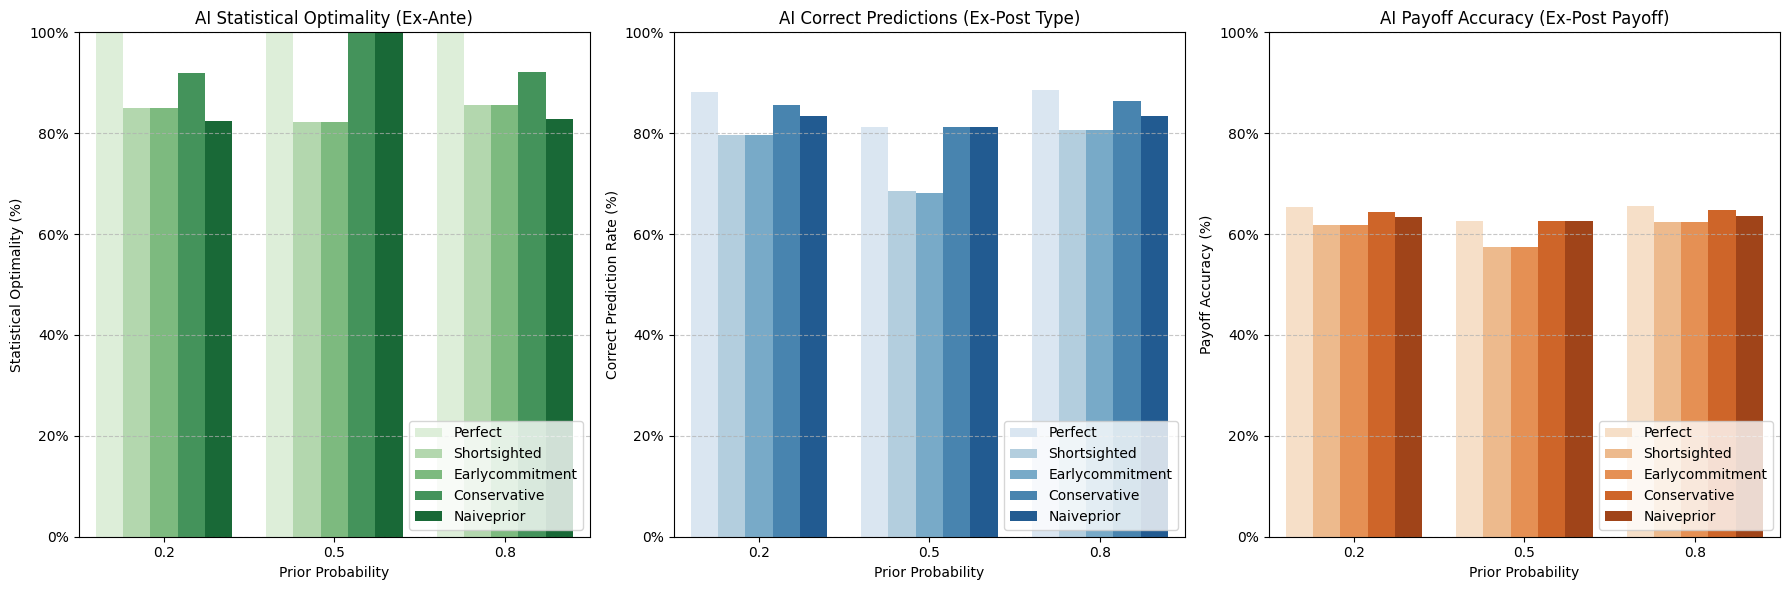


ACCURACY ACROSS TRIALS


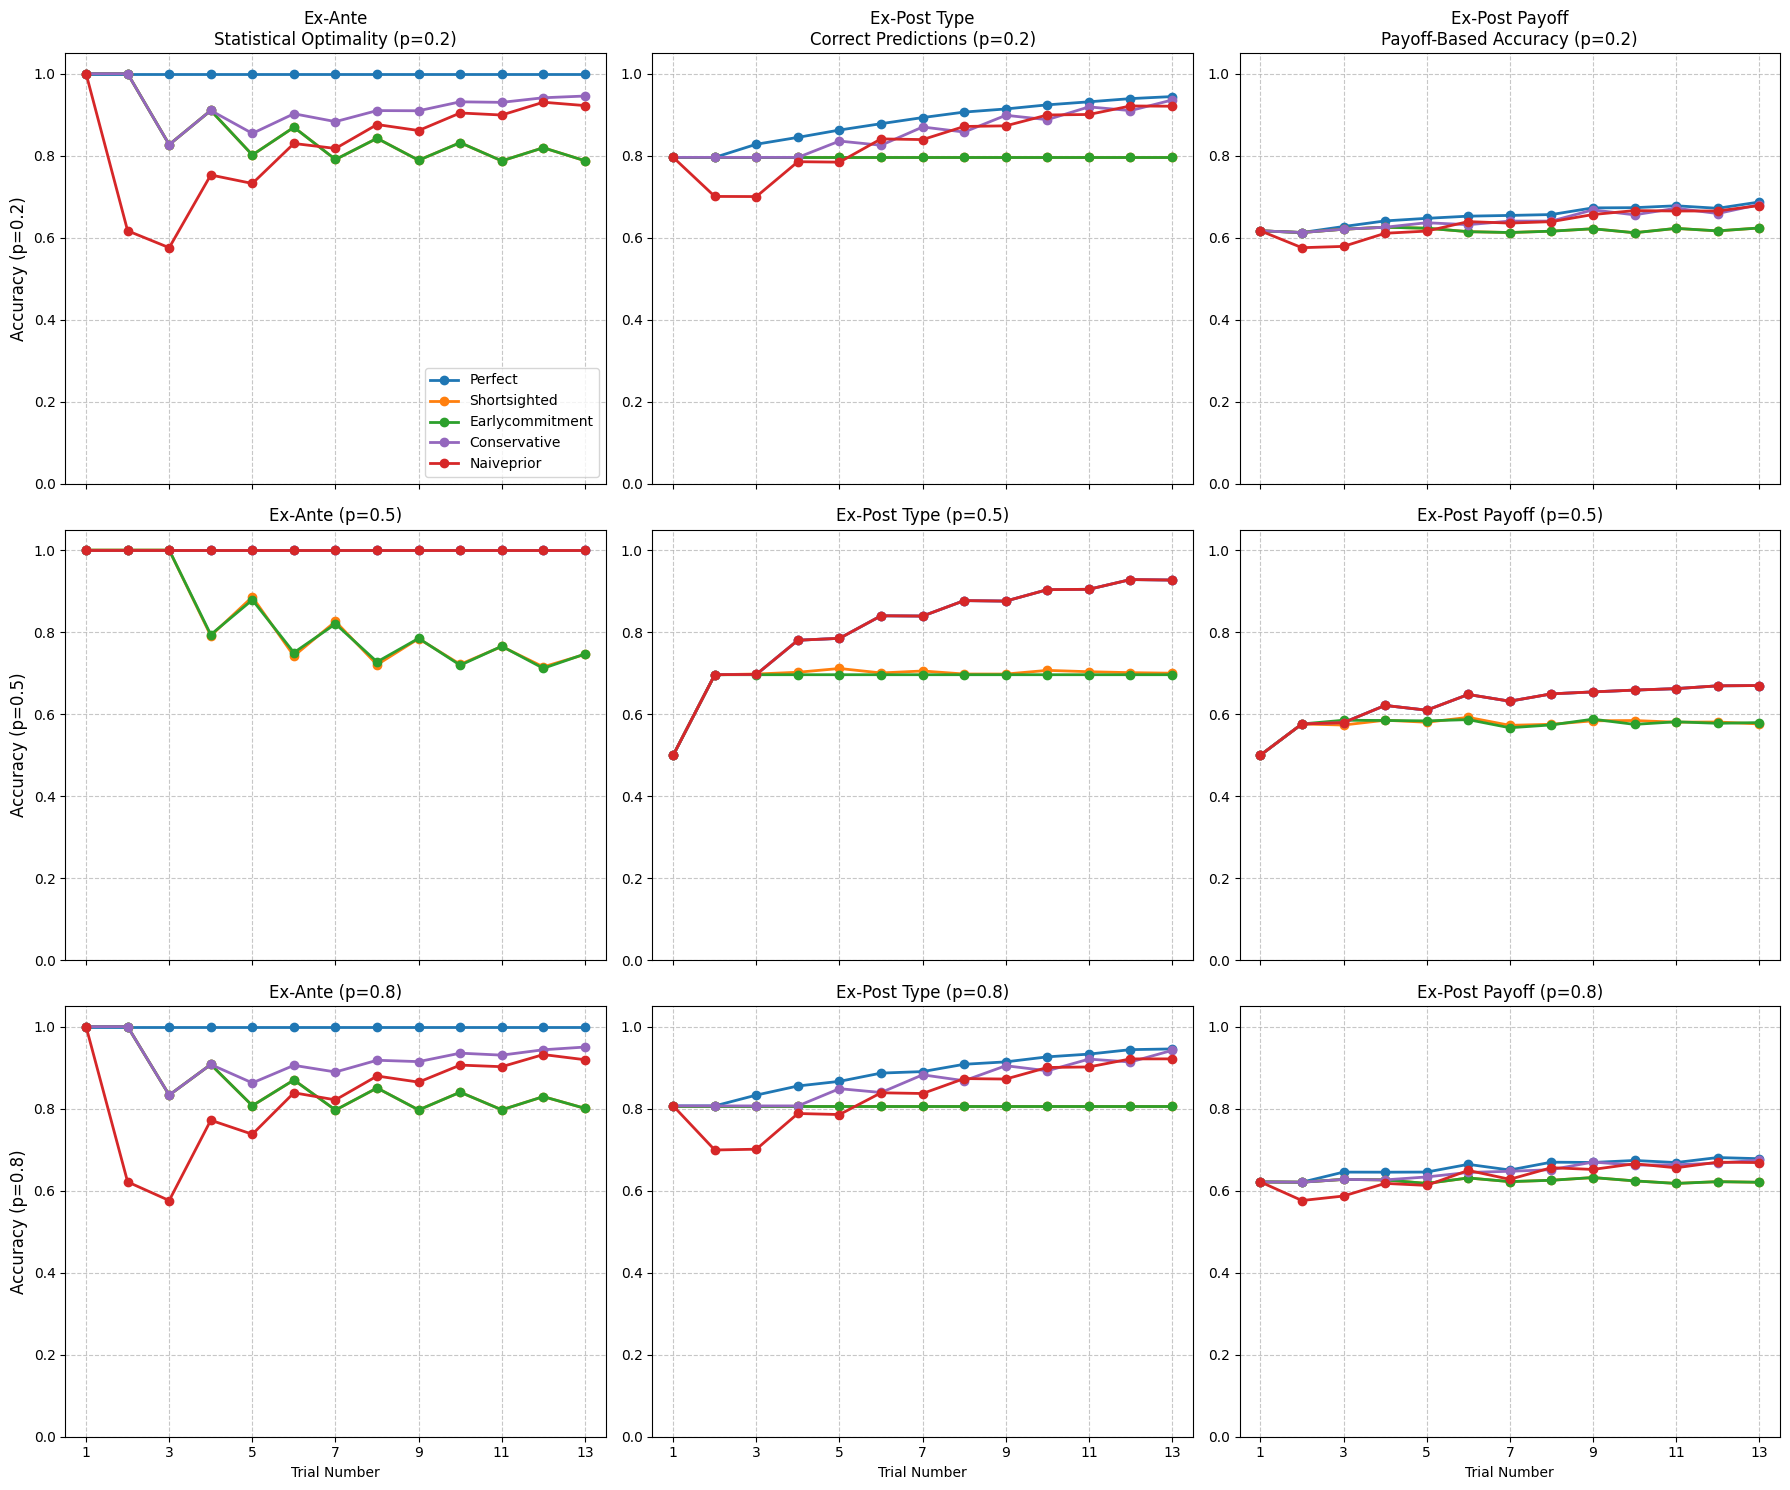


========== ANALYTICAL RESULTS ==========
Exact mathematical solution for all possible sequences

Analytical Results Table:
Number of trials num_trials=13

===== p = 0.2 =====
  perfect         => ex-ante=1.0000, ex-post-type=0.8827, ex-post-payoff=0.6531
  shortsighted    => ex-ante=0.8531, ex-post-type=0.8000, ex-post-payoff=0.6200
  earlycommitment => ex-ante=0.8531, ex-post-type=0.8000, ex-post-payoff=0.6200
  conservative    => ex-ante=0.9204, ex-post-type=0.8593, ex-post-payoff=0.6437
  naiveprior      => ex-ante=0.8259, ex-post-type=0.8335, ex-post-payoff=0.6334

===== p = 0.5 =====
  perfect         => ex-ante=1.0000, ex-post-type=0.8104, ex-post-payoff=0.6242
  shortsighted    => ex-ante=0.8222, ex-post-type=0.6846, ex-post-payoff=0.5738
  earlycommitment => ex-ante=0.8222, ex-post-type=0.6846, ex-post-payoff=0.5738
  conservative    => ex-ante=1.0000, ex-post-type=0.8104, ex-post-payoff=0.6242
  naiveprior      => ex-ante=1.0000, ex-post-type=0.8104, ex-post-payoff=0.6242

==

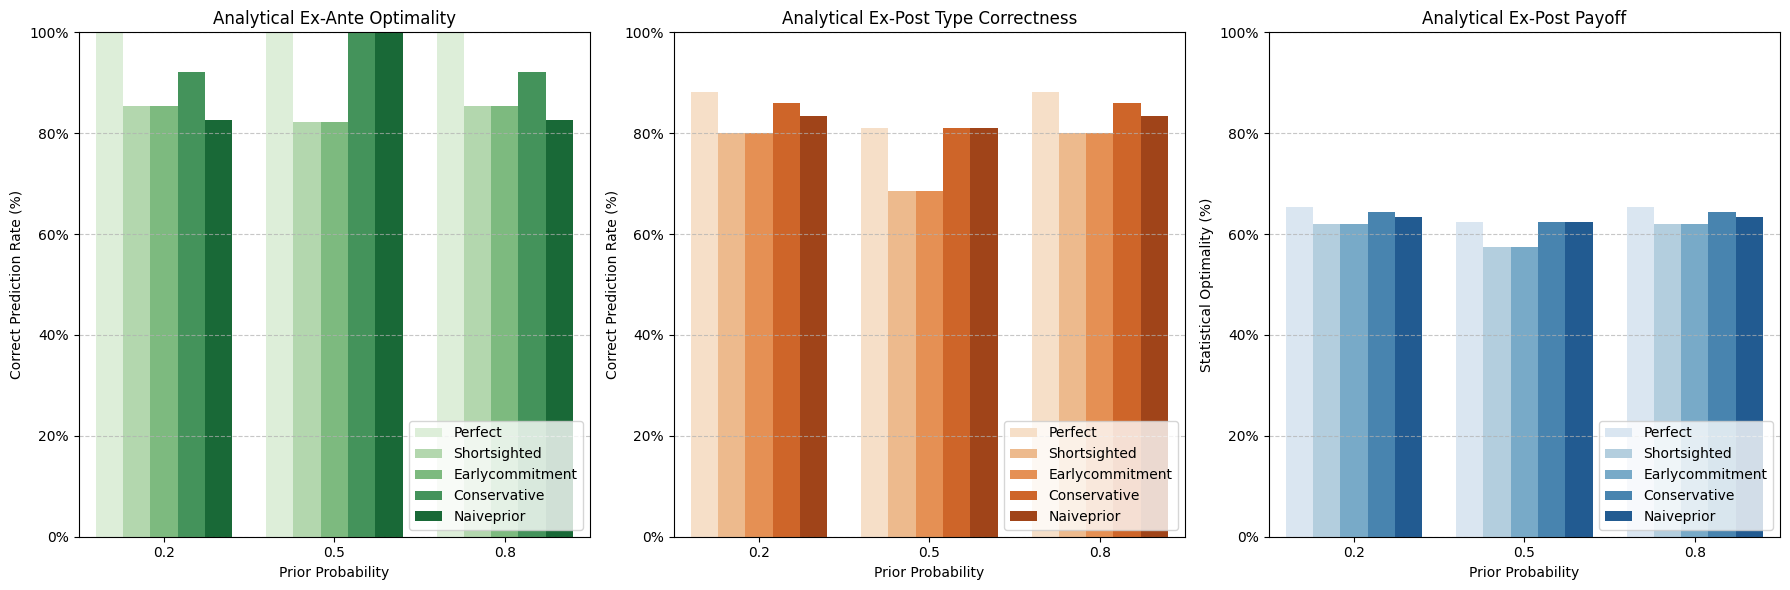

In [216]:
# Run the analysis
if __name__ == "__main__":
    # Run with default configuration
    config = DEFAULT_CONFIG
    config, results = main(config, run_analytical=True)
    
    # Alternatively, you can override configurations:
    # custom_config = SimulationConfig(
    #     p=[0.3, 0.5, 0.7],  # Different priors
    #     q=0.6,              # Different q
    #     high_payoff=10,     # Different payoffs
    #     low_payoff=0,
    #     bond_payoff=5,
    #     num_trials=10,      # Fewer trials
    #     num_simulations=1000,  # Fewer simulations
    #     ai_types=['perfect', 'shortsighted', 'conservative'],  # Subset of AIs
    #     beta=0.3            # Different beta
    # )
    # results = main(custom_config)
    
    # Or just override the number of simulations:
    # results = main(num_simulations_override=500)
